In [1]:
import polars as pl
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Downloads and loads the dataset from Kaggle and returns the CSV path
def download_data() -> str:
    path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
    files = os.listdir(path)
    csv_file = files[0]
    return os.path.join(path, csv_file)

# Reads in the dataset using Polars
def load_data(csv_path: str) -> pl.DataFrame:
    return pl.read_csv(csv_path, encoding="ISO-8859-1")

# Load the data
df = load_data(download_data())

In [3]:
# Inspect the dataset using Polars

# Print the shape of the dataset
print(f"Shape of the dataset: {df.shape}")  # (rows, columns)

# Display the first few rows of the dataset
print("\nFirst five rows of the dataset:")
print(df.head(5))

# General information about the dataset
print("\nGeneral information about the dataset:")
print(df.describe())  # Polars describe gives summary stats including count, mean, min, max, etc.

# Data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Check for missing values
print("\nMissing values in each column:")
missing_values = df.null_count()
print(missing_values)

# Check for duplicate rows
duplicate_count = df.unique(subset=df.columns, keep="first").height
total_rows = df.height
num_duplicates = total_rows - duplicate_count
print(f"\nNumber of duplicate rows in the dataset: {num_duplicates}")

# Check unique genres
unique_genres = df['track_genre'].unique()
print("\nUnique Genres:")
print(unique_genres)

# Get list of numeric column names
numeric_cols = [col for col, dtype in zip(df.columns, df.dtypes)
                if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                             pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                             pl.Float32, pl.Float64)]

# Compute summary statistics for numeric columns
if numeric_cols:
    print(df.select(numeric_cols).describe())
else:
    print("No numeric columns found in the dataset.")


Shape of the dataset: (114000, 21)

First five rows of the dataset:
shape: (5, 21)
┌─────┬─────────────┬─────────────┬─────────────┬───┬─────────┬─────────┬─────────────┬────────────┐
│     ┆ track_id    ┆ artists     ┆ album_name  ┆ … ┆ valence ┆ tempo   ┆ time_signat ┆ track_genr │
│ --- ┆ ---         ┆ ---         ┆ ---         ┆   ┆ ---     ┆ ---     ┆ ure         ┆ e          │
│ i64 ┆ str         ┆ str         ┆ str         ┆   ┆ f64     ┆ f64     ┆ ---         ┆ ---        │
│     ┆             ┆             ┆             ┆   ┆         ┆         ┆ i64         ┆ str        │
╞═════╪═════════════╪═════════════╪═════════════╪═══╪═════════╪═════════╪═════════════╪════════════╡
│ 0   ┆ 5SuOikwiRyP ┆ Gen Hoshino ┆ Comedy      ┆ … ┆ 0.715   ┆ 87.917  ┆ 4           ┆ acoustic   │
│     ┆ MVoIQDJUgSV ┆             ┆             ┆   ┆         ┆         ┆             ┆            │
│ 1   ┆ 4qPNDBW1i3p ┆ Ben         ┆ Ghost       ┆ … ┆ 0.267   ┆ 77.489  ┆ 4           ┆ acoustic   │
│     ┆ 

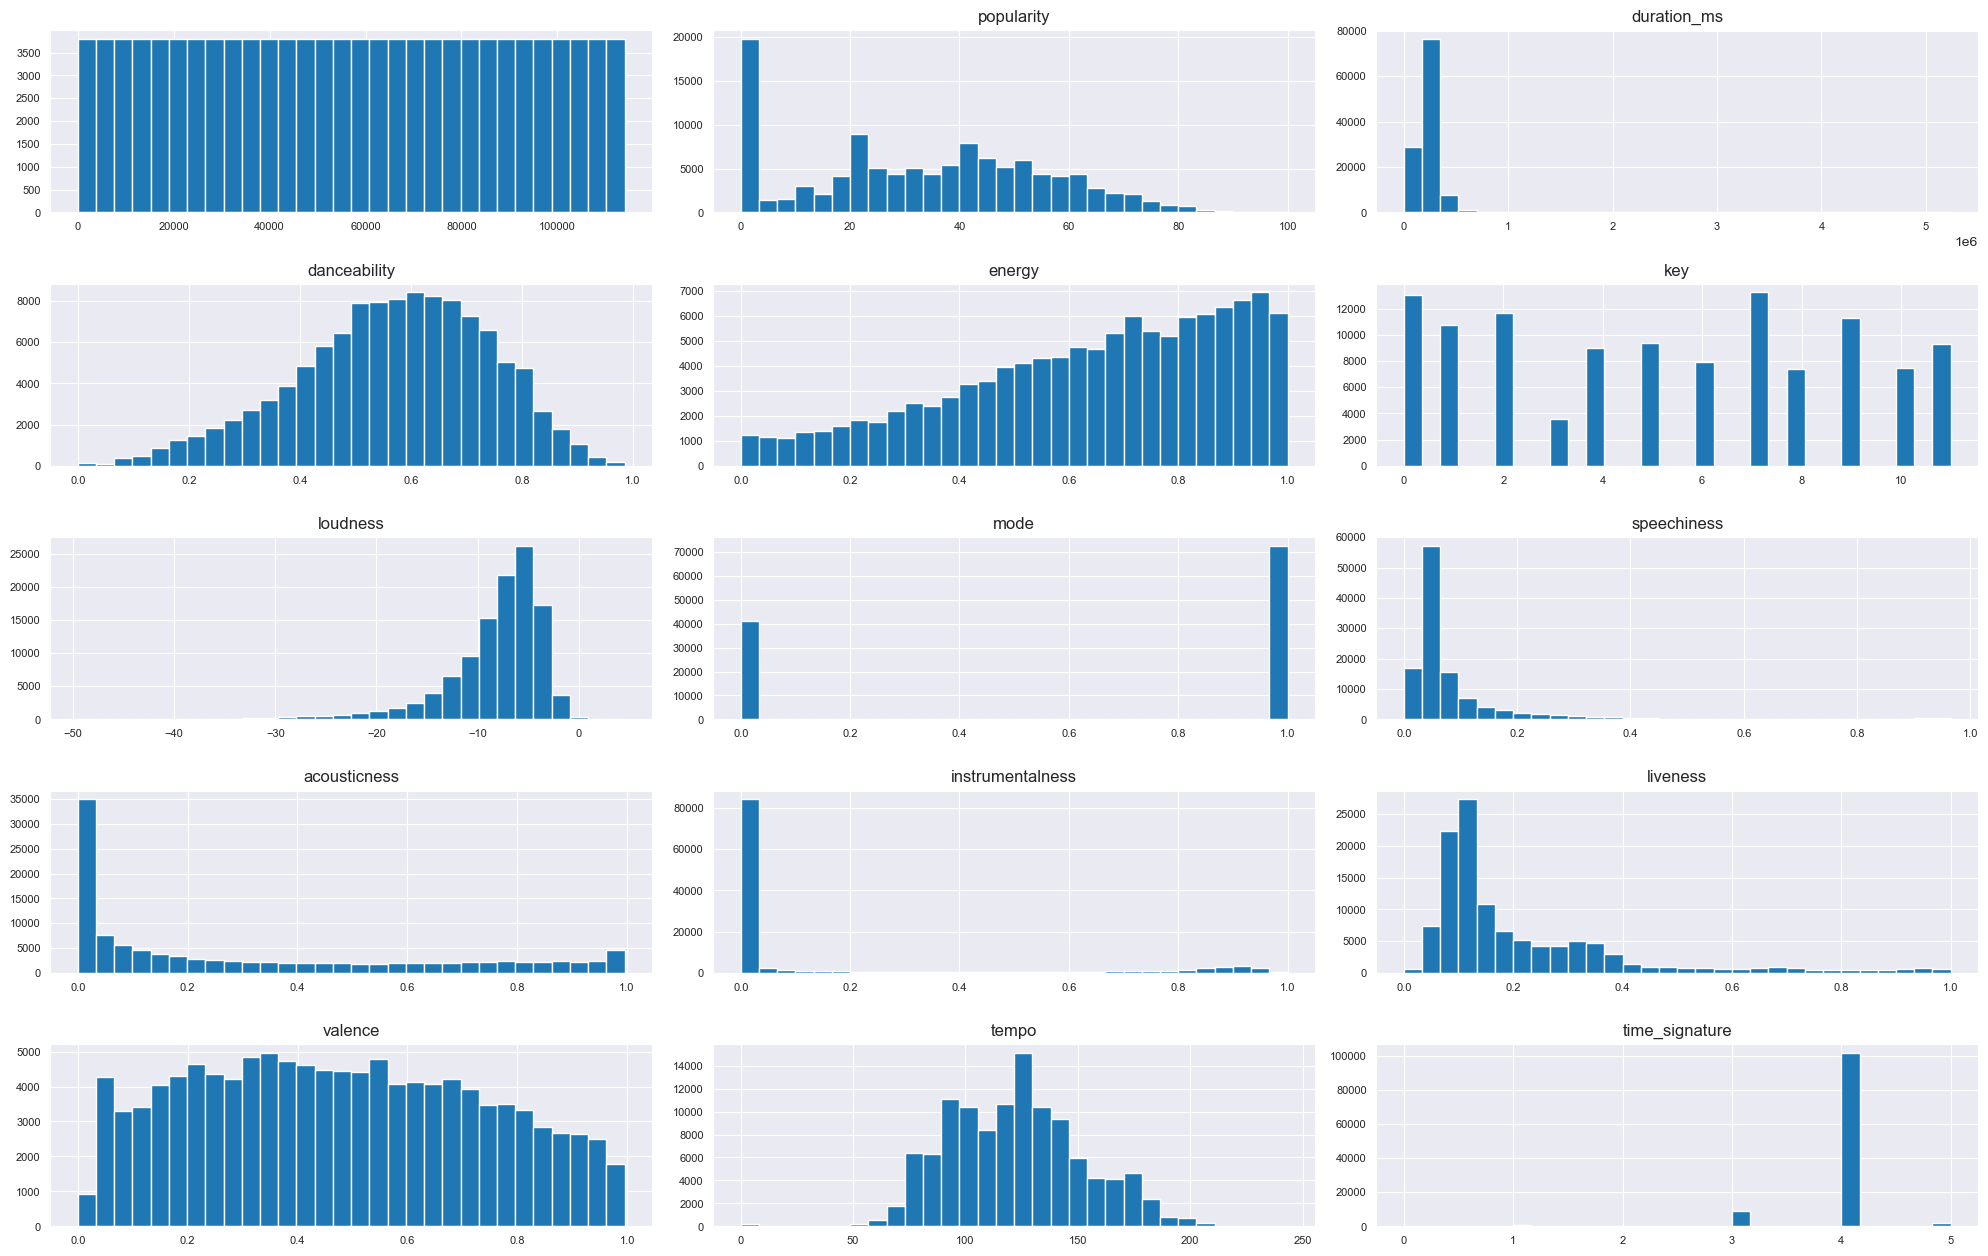

In [4]:
# Convert numeric columns to a dictionary of lists for plotting
numeric_data = {col: df[col].to_list() for col in numeric_cols}

# Plot histograms
sns.set_style('darkgrid')
fig, axes = plt.subplots(len(numeric_cols)//3 + 1, 3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(numeric_data[col], bins=30)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/var/folders/kk/mftjtndn3s9g02vfmgsch7qr0000gn/T/ipykernel_68214/2610780290.py:53: UserWarning: Glyph 147 (\x93) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kk/mftjtndn3s9g02vfmgsch7qr0000gn/T/ipykernel_68214/2610780290.py:53: UserWarning: Glyph 154 (\x9a) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 147 (\x93) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 154 (\x9a) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


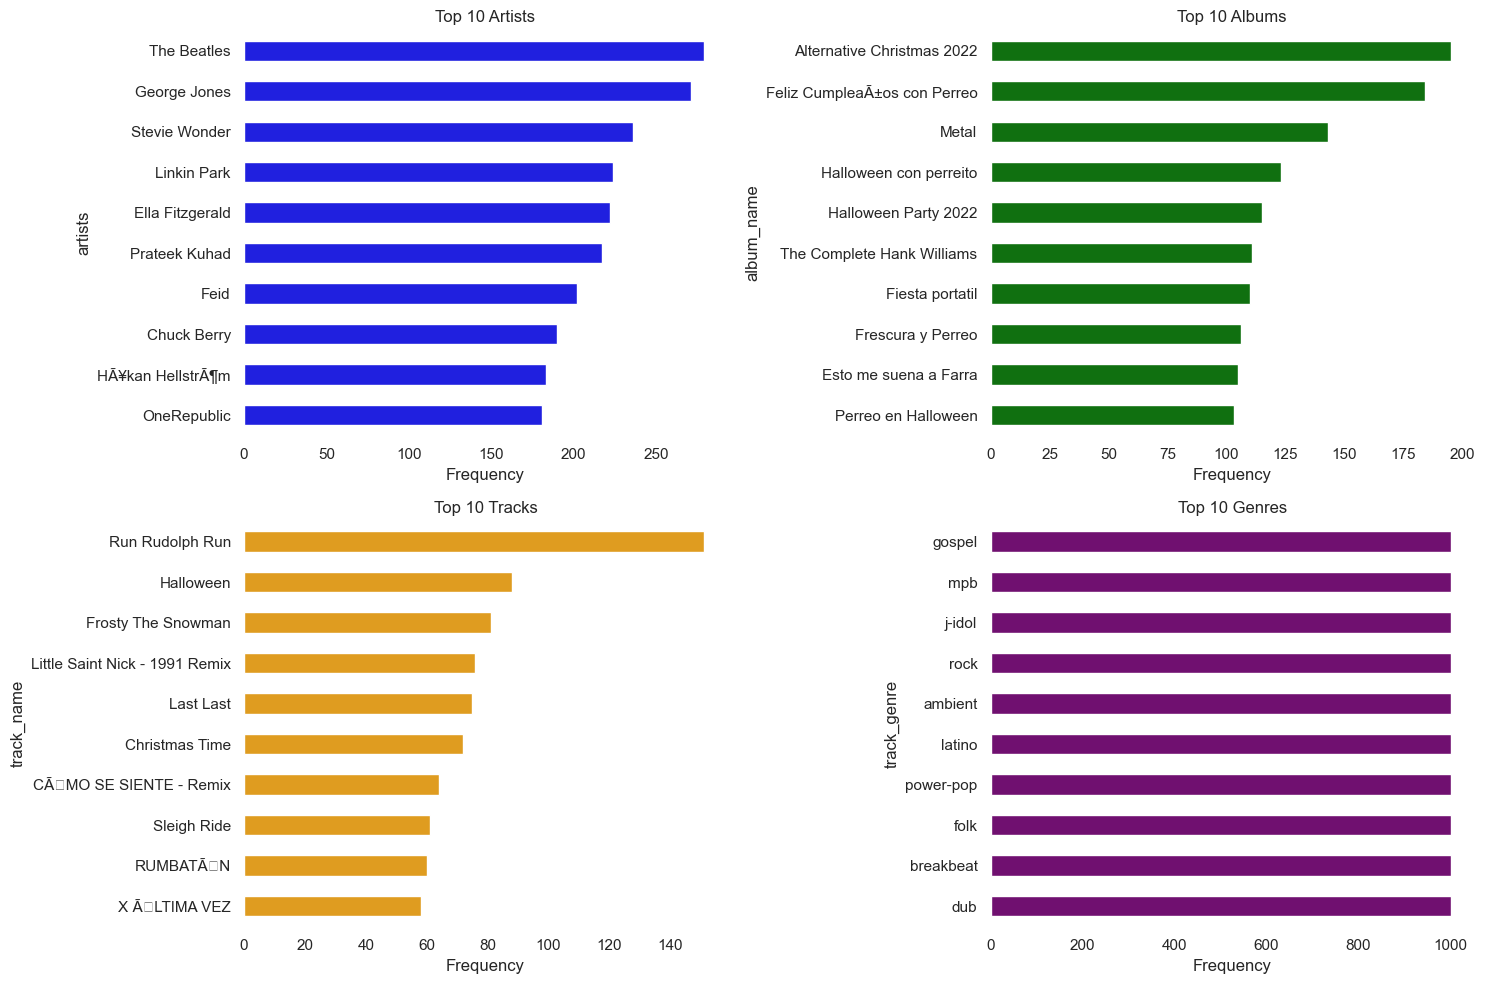

In [5]:
# Plot settings
sns.set_style('white')
sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})
top_n = 10

# Helper: convert Polars top-N result to pandas Series (index=name, values=count)
def to_pandas_series(polars_df, name_col, count_col="len"):
    return polars_df.to_pandas().set_index(name_col)[count_col]

# Get top N using group_by + len (robust and clear)
top_artists_pd = to_pandas_series(
    df.group_by("artists").len().sort("len", descending=True).head(top_n),
    "artists"
)
top_albums_pd = to_pandas_series(
    df.group_by("album_name").len().sort("len", descending=True).head(top_n),
    "album_name"
)
top_tracks_pd = to_pandas_series(
    df.group_by("track_name").len().sort("len", descending=True).head(top_n),
    "track_name"
)
top_genres_pd = to_pandas_series(
    df.group_by("track_genre").len().sort("len", descending=True).head(top_n),
    "track_genre"
)

# Plot
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    sns.barplot(x=top_artists_pd.values, y=top_artists_pd.index, color='blue', ax=axes[0,0], orient='h', zorder=3, width=0.5)
    axes[0,0].set_title(f'Top {top_n} Artists')
    axes[0,0].set_xlabel('Frequency')
    axes[0,0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    sns.barplot(x=top_albums_pd.values, y=top_albums_pd.index, color='green', ax=axes[0,1], orient='h', zorder=3, width=0.5)
    axes[0,1].set_title(f'Top {top_n} Albums')
    axes[0,1].set_xlabel('Frequency')
    axes[0,1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    sns.barplot(x=top_tracks_pd.values, y=top_tracks_pd.index, color='orange', ax=axes[1,0], orient='h', zorder=3, width=0.5)
    axes[1,0].set_title(f'Top {top_n} Tracks')
    axes[1,0].set_xlabel('Frequency')
    axes[1,0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    sns.barplot(x=top_genres_pd.values, y=top_genres_pd.index, color='purple', ax=axes[1,1], orient='h', zorder=3, width=0.5)
    axes[1,1].set_title(f'Top {top_n} Genres')
    axes[1,1].set_xlabel('Frequency')
    axes[1,1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    plt.tight_layout()
    plt.show()

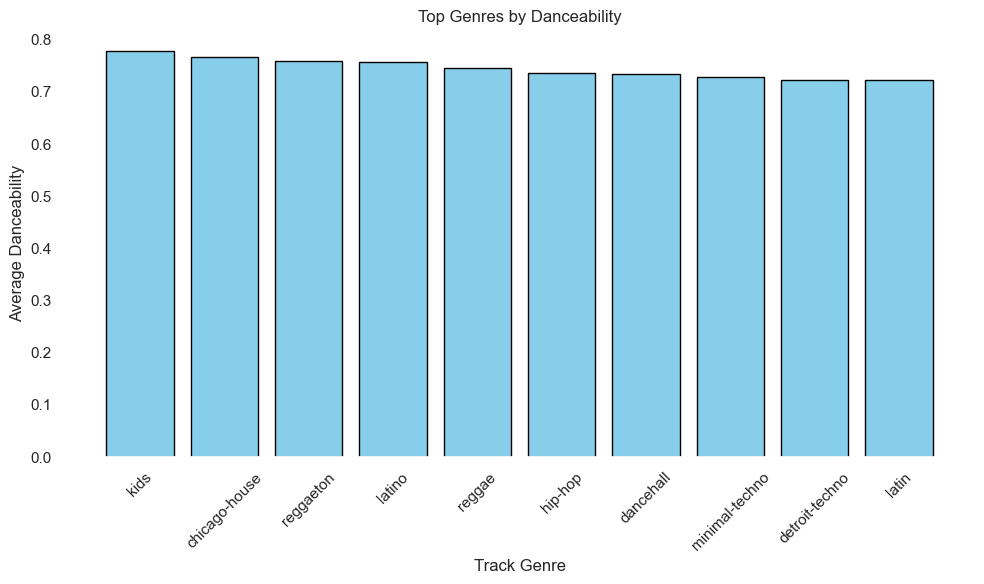

In [6]:
# Define feature columns
feature_cols = ['danceability', 'energy', 'acousticness', 'speechiness']

# Group by 'track_genre', compute mean for selected features, and reset index
genre_avg = (
    df
    .group_by('track_genre')
    .agg(pl.col(feature_cols).mean())
    .sort('danceability', descending=True)
    .head(10)
)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(genre_avg['track_genre'], genre_avg['danceability'], color='skyblue', edgecolor='black')
plt.title('Top Genres by Danceability')
plt.xlabel('Track Genre')
plt.ylabel('Average Danceability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

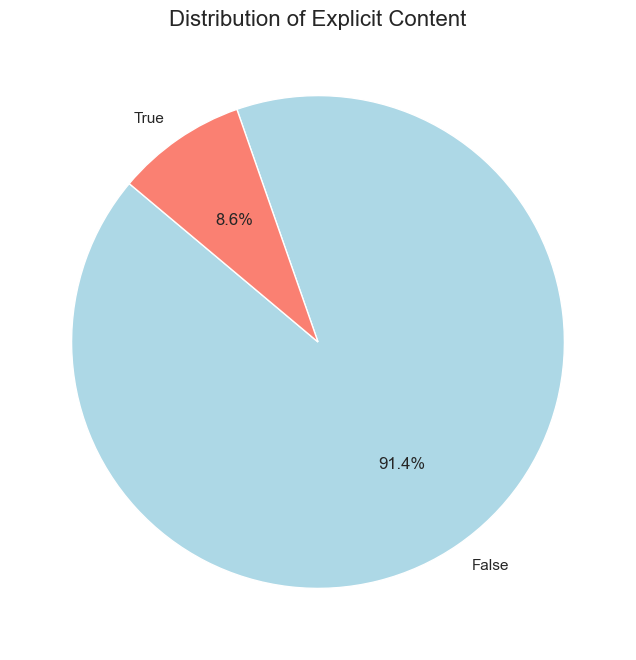

In [7]:
# Get value counts from the 'explicit' Series
explicit_counts = (
    df['explicit']               # This is a Series
    .value_counts()              # Returns a DataFrame with 'explicit' and 'count'
    .sort('explicit')            # Optional: sort by explicit value (e.g., False, then True)
)

# Extract labels and sizes
labels = explicit_counts['explicit'].to_list()
sizes = explicit_counts['count'].to_list()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=['lightblue', 'salmon']
)
plt.title('Distribution of Explicit Content', fontsize=16)
plt.show()

/var/folders/kk/mftjtndn3s9g02vfmgsch7qr0000gn/T/ipykernel_68214/3964284105.py:1: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  numerical_cols = df.select(pl.col(pl.NUMERIC_DTYPES))


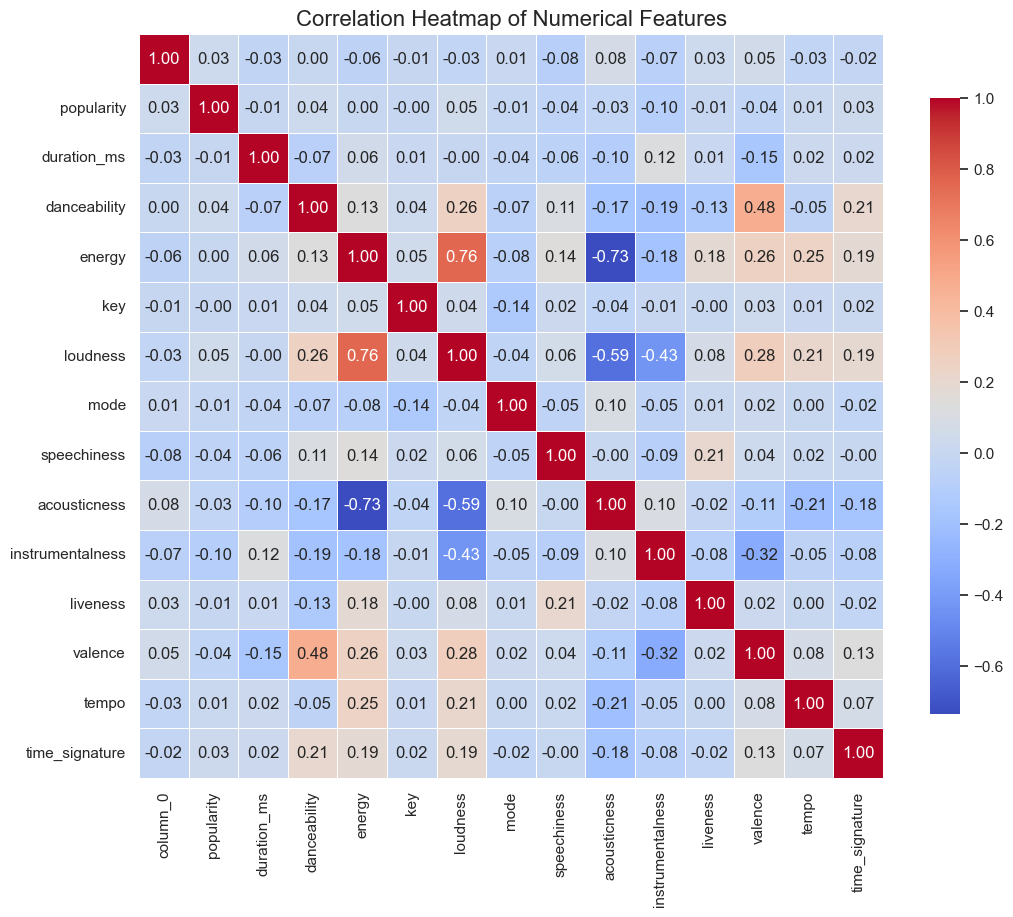

In [10]:
numerical_cols = df.select(pl.col(pl.NUMERIC_DTYPES))
# Get column names
cols = numerical_cols.columns

# Compute correlation matrix as a Polars DataFrame
corr_exprs = [
    pl.corr(pl.col(col1), pl.col(col2)).alias(f"{col2}")
    for col1 in cols
    for col2 in cols
]

# But this would give a single row; better: compute row-by-row
# Efficient approach: use select with dynamic expressions per row

# Alternative: use list comprehension to build each row as a Series
corr_rows = []
for col1 in cols:
    row = numerical_cols.select(
        [pl.corr(pl.col(col1), pl.col(col2)).alias(col2) for col2 in cols]
    ).row(0)  # extract first (and only) row as tuple
    corr_rows.append(row)

# Create Polars DataFrame with proper index-like column
corr_df = pl.DataFrame(corr_rows, schema=cols)

# Add row labels (optional for debugging; not needed for heatmap)
# For seaborn, we just need a square matrix with matching columns/index
corr_pandas = corr_df.to_pandas()
corr_pandas.index = cols  # Ensure row labels match column names

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_pandas,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8},
    linewidths=0.5
)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

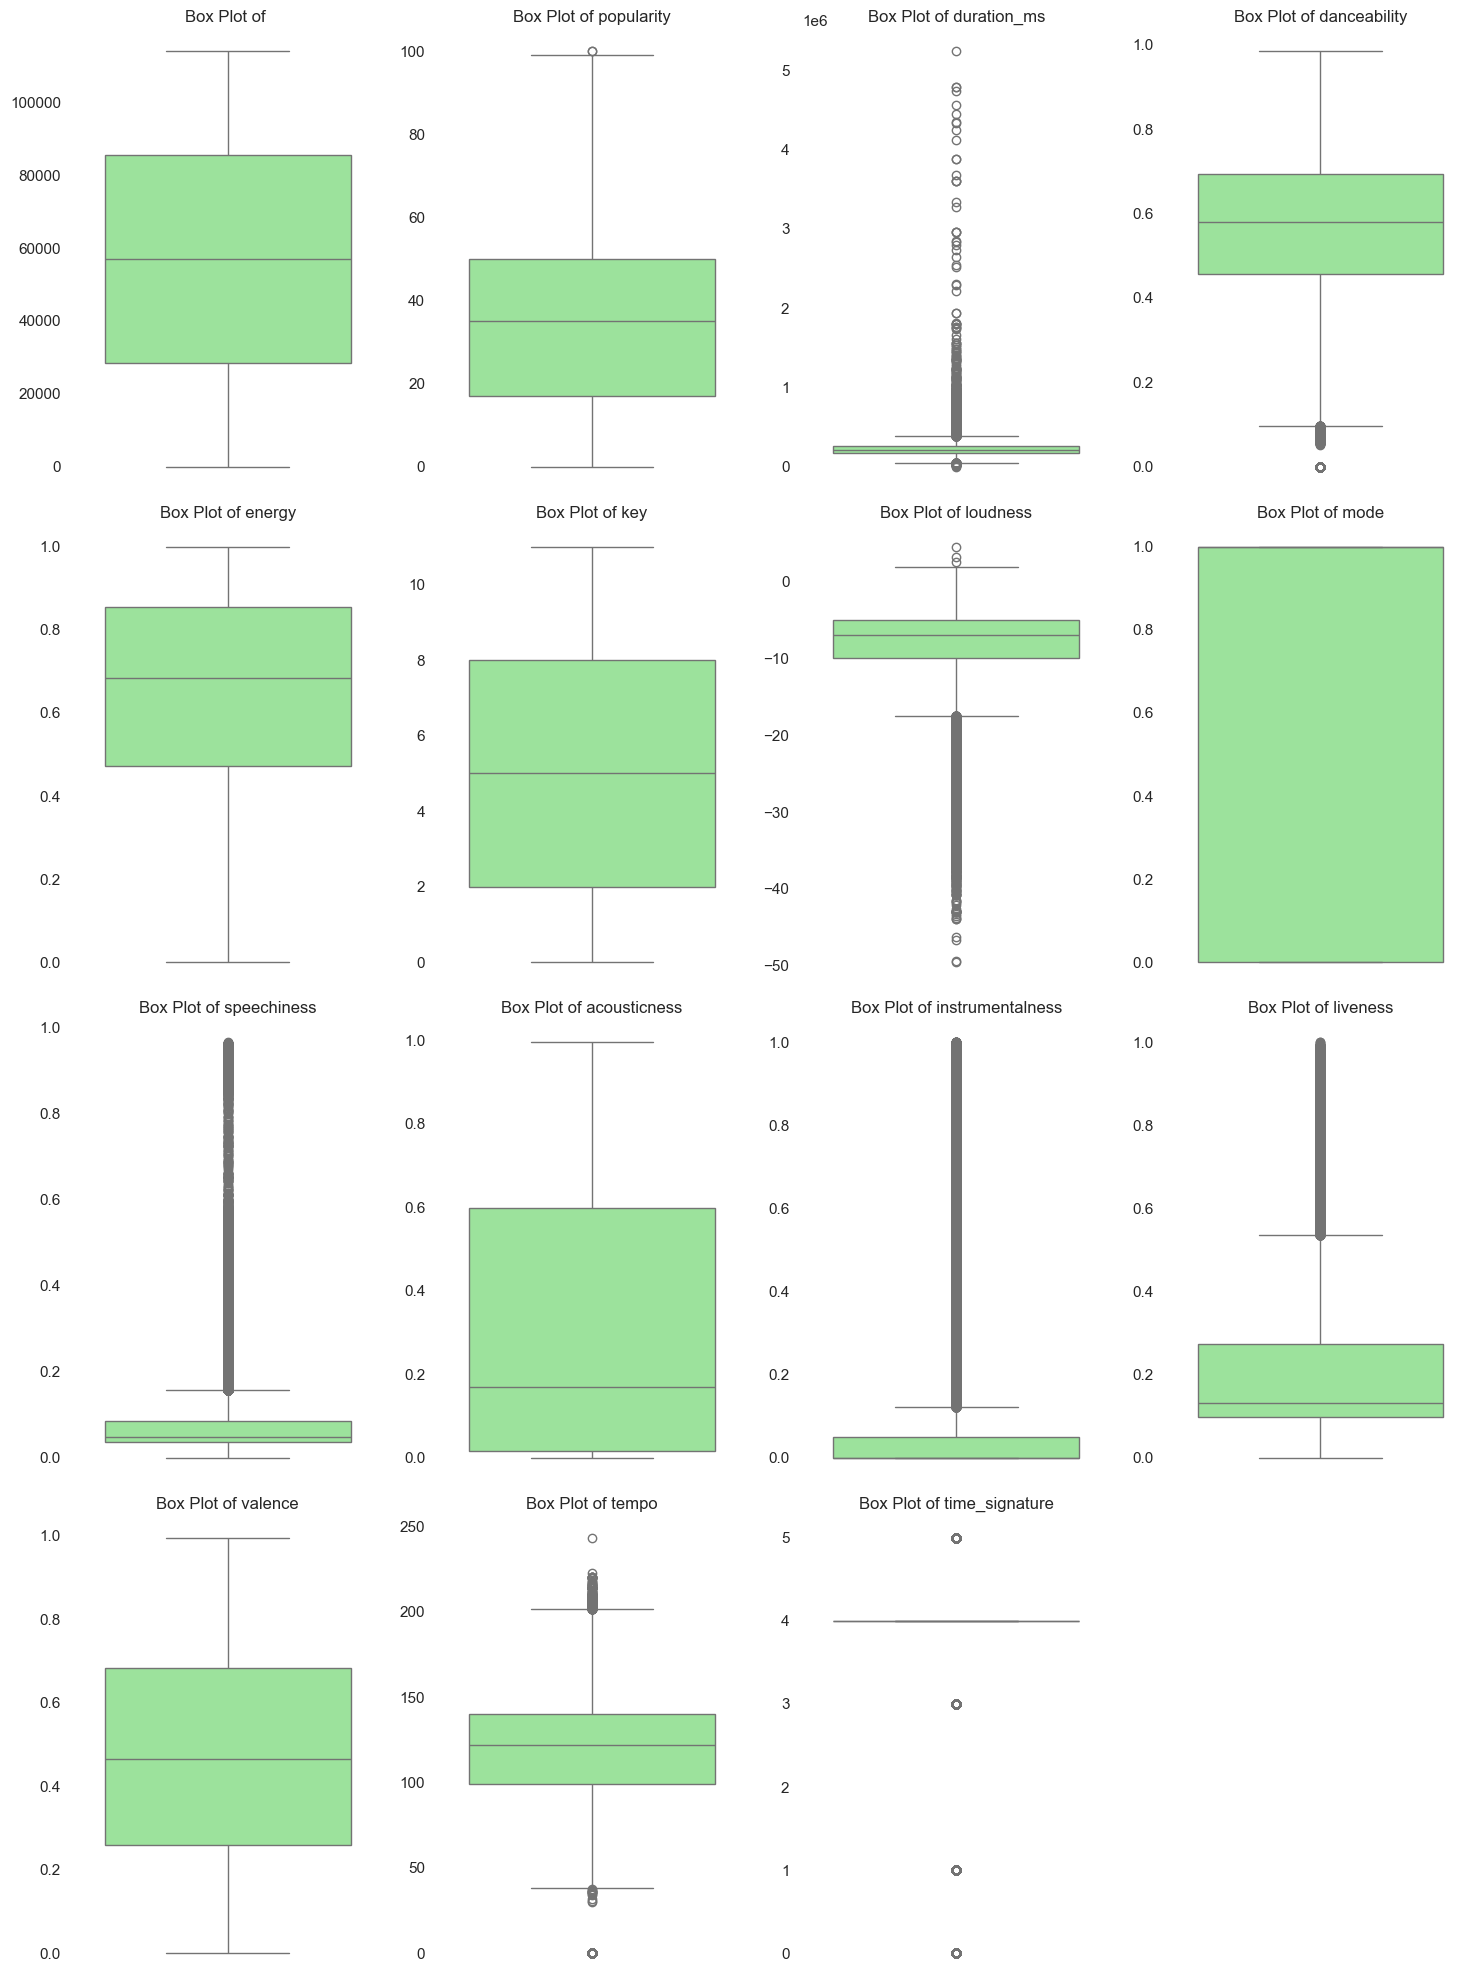

In [11]:
num_features = len(numerical_cols.columns)
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols

# 3. Plot boxplots
plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(numerical_cols.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Convert Polars Series to numpy (or list) for seaborn
    data = df[col].to_numpy()  # or .to_list()
    
    sns.boxplot(y=data, color='lightgreen')
    plt.title(f'Box Plot of {col}')
    
plt.tight_layout()
plt.show()

In [13]:
# Top 10 most danceable tracks (Polars)
top_danceable = (
    df
    .sort('danceability', descending=True)
    .head(10)
    .select(['track_name', 'artists', 'danceability'])
)

print("\nTop 10 Most Danceable Tracks:")
print(top_danceable)


Top 10 Most Danceable Tracks:
shape: (10, 3)
┌─────────────────────────────────┬─────────────────────────────────┬──────────────┐
│ track_name                      ┆ artists                         ┆ danceability │
│ ---                             ┆ ---                             ┆ ---          │
│ str                             ┆ str                             ┆ f64          │
╞═════════════════════════════════╪═════════════════════════════════╪══════════════╡
│ Sol Clap                        ┆ Quantic                         ┆ 0.985        │
│ Medicaid Baby                   ┆ That Girl Lay Lay               ┆ 0.984        │
│ Inspiration                     ┆ Delano Smith                    ┆ 0.983        │
│ Daily Routines                  ┆ Oliver Schories                 ┆ 0.982        │
│ Bitches                         ┆ dj funk                         ┆ 0.981        │
│ Featuring Mixx Master Lee, Red… ┆ Mixx Master Lee                 ┆ 0.981        │
│ Plastik Fantastik

In [14]:
# Top 10 artists by number of tracks (Polars)
top_artists_tracks = (
    df['artists']
    .value_counts()
    .sort('count', descending=True)
    .head(10)
)

print("\nTop 10 Artists by Number of Tracks:")
print(top_artists_tracks)


Top 10 Artists by Number of Tracks:
shape: (10, 2)
┌───────────────────┬───────┐
│ artists           ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ The Beatles       ┆ 279   │
│ George Jones      ┆ 271   │
│ Stevie Wonder     ┆ 236   │
│ Linkin Park       ┆ 224   │
│ Ella Fitzgerald   ┆ 222   │
│ Prateek Kuhad     ┆ 217   │
│ Feid              ┆ 202   │
│ Chuck Berry       ┆ 190   │
│ HÃ¥kan HellstrÃ¶m ┆ 183   │
│ OneRepublic       ┆ 181   │
└───────────────────┴───────┘


In [ ]:
# Top 10 songs by popularity (Polars)
top_popular_songs = (
    df
    .sort('popularity', descending=True)
    .head(10)
    .select(['track_name', 'artists', 'popularity'])
)

print("\nTop 10 Songs by Popularity:")
print(top_popular_songs)